<a href="https://colab.research.google.com/github/LaraNegri/EntregasPDI/blob/main/Trabajo_Final_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo Final Procesamiento Digital de Imágenes

## Lara Negri - Julio 2022

Carrera: Lic. en Física \\
Contacto: laranegri98@gmail.com

### Introducción

En este trabajo, se estudió el dewetting de films delgados de poli-estireno (PS) con espesores en el rango entre los 40 y 90 nanómetros. Como sustrato se utilizó silicio monocristalino. Utilizando un microscopio óptico y un microscopio de fuerza atómica (AFM) se caracterizó la formación de un patrón de gotas sobre el sustrato. \\
Se analizó la distribución de formas de las gotas, su área, perímetro, excentricidad, ejes mayor y menor y ángulo de inclinación.

### Objetivos

El objetivo del trabajo es crear un código que permita obtener, a partir de la imagen original, los parámetros geométricos mencionados.
Es importante destacar que como imagen inicial no se trabaja directamente con lo obtenido del microscopio AFM, sino que se le hizo un tratamiento previo con el software Gwyddion. Este último fue diseñado especialmente para trabajar con este tipo de imágenes, por lo que permite al usuario eliminar artifacts propios de este tipo de microscopio en simples pasos. 

En el desarrollo del trabajo no se utilizaran funciones pre-existentes de las librerías de Python para analisis de imágenes, sino que se desarrolla desde cero, utilizando sólo las funciones más básicas.

### Código

Importo librerías

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import imageio as io
from scipy.signal import convolve2d

Para simplificar la lectura del código se decidió crear funciones. De esta forma, procesos que se debían repetir más de una vez, solo implicaban tener que llamar a la función una vez más (simplemente una nueva línea de código), sin tener que volver a escribir todo el código nuevamente. 

Funciones a utilizar

In [18]:
# Función para leer una imagen y tenerla como Array numpy sin limitación uint8
def get_image(rute):
  """
  Con la dirección a la imagen leo la imagen en el código.
  Se asigna tipo np.float a los píxeles de la imagen
  """
  im = io.imread(rute)
  im = im.astype(np.float)
  return im

#Función para pasar una imagen de RGBA a YIQ
def rgbatoyiq(im):
    """
    Cargo la imagen en RGBA (o RGB) y la transformo a YIQ
    """
    Shape = im.shape
    im_YIQ = np.zeros((Shape[0], Shape[1], 3))
    [im_YIQ[:,:,0], im_YIQ[:,:,1], im_YIQ[:,:,2]] = (np.matmul(np.array([[0.299, 0.587, 0.114],
              [0.595716, -0.274453, -0.321263],
              [0.211456, -0.522591, 0.311135]]), (np.array([im[:,:,0], im[:,:,1], im[:,:,2]])/255).transpose(1,0,2))).transpose(1,0,2)
    im_YIQ[:,:,0] = np.clip(im_YIQ[:,:,0], 0, 1)
    im_YIQ[:,:,1] = np.clip(im_YIQ[:,:,1], -0.5957, 0.5957)
    im_YIQ[:,:,2] = np.clip(im_YIQ[:,:,2], -0.5226, 0.5226)
    return im_YIQ

#Función para pasar una imagen de YIQ a RGB (útil para poder plotear imágenes)
def yiqtorgb(im):
    """
    Cargo la imagen en YIQ y la transformo a RGB
    """
    Shape = im.shape
    im_RGB = np.zeros((Shape[0], Shape[1], 3))
    [im_RGB[:,:,0], im_RGB[:,:,1], im_RGB[:,:,2]] = 255*(np.matmul(np.array([[1, 0.9663, 0.6210],
              [1, -0.2721, -0.6474],
              [1, -1.1070, 1.7046]]), (np.array([im[:,:,0], im[:,:,1], im[:,:,2]])).transpose(1,0,2))).transpose(1,0,2)
    im_RGB = im_RGB.astype(np.uint8)
    im_RGB[:,:,:] = np.clip(im_RGB[:,:,:], 0, 255)
    return im_RGB

Estas primeras 3 funciones son muy sencillas y se utilizan para el trabajo básico con la imagen. 
En primer lugar se tiene una función que permite leer la imagen y asignarle un valor float los píxeles. 

Luego están las funciones que me permiten pasar de RGB a YIQ y viceversa.

En el caso de la función *rgbatoyiq*, dado que la imagen inicial se encuentra en formato RGBA (4 canales), donde el canal A no aporta información útil para nuestro trabajo, simplemente se ignora el 4to canal al realizar la conversión.

In [19]:
def pixel_analisis(im_YIQ_new, im_YIQ, i_values, j_values, gotas_list, rcm_gotas, perimetros_tot_gota):
    """
    Leo una imagen, y obtengo la cantidad de "manchas" presentes en la imagen. 
    También calculo el centro de masa de cada una de ellas, y su perímetro.
    Además, obtengo la cantidad de píxeles que hay en cada gota, para luego poder calcular el área de las mismas
    """
    nro_neighbour = []

    #Trabajo con la imagen binarizada; debo ubicar dónde están los píxeles con luminancia 1 (es decir, mis manchas)
    first_pix_xy = (np.where(im_YIQ_new == 1)[0][0], np.where(im_YIQ_new == 1)[1][0]) #Coordenadas de un pixel aleatorio donde Y = 1
    
    #¿Qué luminancia tienen sus vecinos?

    pixels_coord_list = [] #lista con coordenadas de puntos con Y = 1
    checked = [] #los pixeles que voy chequeando les asigno valor 1
    tmp_pixels_coord_list = [] #hago una lista temporal donde guardo SOLO los pixeles que faltan chequear. Los que ya chequee
    #aparecen en pixels_coord_list, pero los borro de esta lista, para no chequear dos veces lo mismo
    
    pixels_coord_list.append([first_pix_xy[0], first_pix_xy[1]])
    tmp_pixels_coord_list.append([first_pix_xy[0], first_pix_xy[1]])
    
    while len(checked) < len(pixels_coord_list): #cuando ya chequee todos los pixeles, termina de correr
     
      for pixel in tmp_pixels_coord_list:
        vecinos = -1
        for i in i_values:
          for j in j_values:
            x, y = pixel[0]+i, pixel[1]+j
            currPix = [x, y]
            if currPix[0]>= im_YIQ_new.shape[0] or currPix[0]<0 or currPix[1]>= im_YIQ_new.shape[1] or currPix[1]<0:
                continue
            else:
                if im_YIQ_new[x, y, 0]==1 and currPix not in pixels_coord_list:
                  pixels_coord_list.append(currPix)
                  tmp_pixels_coord_list.append(currPix)
                if im_YIQ[x, y, 0]==1:
                    vecinos += 1
        
        nro_neighbour.append(vecinos) 
        checked.append(1) #los pixeles que pasaron por este for, ya fueron chequeados
        tmp_pixels_coord_list.remove(tmp_pixels_coord_list[tmp_pixels_coord_list.index(pixel)])
        im_YIQ_new[pixel[0], pixel[1]] = 0 #los que ya chequee, les pongo luminancia = 0, para ya sacarlos de la imagen
        
    perimetro_n_gota = len(nro_neighbour) - nro_neighbour.count(8) - nro_neighbour.count(7) #sumo todos los pixeles menos los que tienen 7 y 8 vecinos
    
    #Los pixeles con 8 vecinos no están en el borde de la gota, están adentro
    #Los de 7 depende de cómo uno considera. Yo elegí que tampoco pertenezcan al borde
    #Explicación en texto

    perimetros_tot_gota.append(perimetro_n_gota) #perimetro de cada gota
    
    gotas_list.append(pixels_coord_list) #Hago un array que contenga un array con las coordenadas de los pixeles de cada gota
    
    im_RGB = yiqtorgb(im_YIQ_new) #para plotear la imagen paso a RGB
    
    if inp == 'Si':
        plt.imshow(im_RGB, 'gray') 
        plt.show()
    
    return nro_neighbour, perimetro_n_gota, pixels_coord_list

*pixel_analisis* es la función principal del código.

La idea detrás de esta función es la siguiente: 
En primer lugar, se trabajó con la imagen binarizada. Por lo tanto, cada gota corresponde a un conjunto de píxeles blancos (Y=1) que tienen al menos un punto adyacente o en diagonal con la misma luminancia, es decir, los píxeles están en contacto unos con otros. Se consideraron contactos adyacentes y diagonales. 

Lo que se debe hacer para poder calcular las propiedades geométricas de cada gota, es determinar qué píxeles corresponden a cada gota. 
Para esto, se eligió un píxel al azar en la imagen cuya luminancia sea Y=1. Así nos aseguramos que el primer pixel (*first_pix_xy*) va a pertenecer a alguna gota.

Una vez que se determinó este primer pixel, se debe analizar la luminancia de sus vecinos. Aquellos vecinos con Y=1 pertenecerán a la gota, no así los píxeles con Y=0. Una vez que se conoce la luminancia de todos los vecinos del pixel, se puede decir que ese pixel fue "chequeado". 

En el código, cada píxel con Y=1 es guardado en la lista *pixels_coord_list*, teniendo en cuenta que si el píxel ya estaba en está lista, no es necesario volverlo a agregar. 

Luego, una vez revisados todos los vecinos, se realizó el mismo procedimiento con el siguiente pixel presente en la lista *pixels_coord_list*. Este proceso se repitió con un ciclo for hasta recorrer todos los píxeles presentes en la lista.

Para no cometer errores y chequear muchas veces un mismo pixel, se creó una lista temporal *tmp_pixels_coord_list* en la que los pixeles que ya habían sido chequeados son eliminados. La lista *pixels_coord_list* sí contiene (al final del código) todos los pixeles con luminancia Y=1 presentes en la imagen. 

Con la misma idea de no chequear varias veces un mismo pixel, se creó una copia (*im_YIQ_new*) de la imagen original, en la que los píxeles ya chequeados se les iba asignando luminancia Y=0, es decir, se "eliminan" de la imagen. Esta es la imagen que se ploteó a medida que se analizó cada pixel. 

A la par de este proceso, se realizó un conteo de número de vecinos. En la variable *nro_neighbour* se registró cuantos vecinos con luminancia Y=1 posee cada pixel analizado. Para esto, cada vez que se detectaba un píxel con Y=1 se sumaba +1 a la variable *vecino* del píxel que estaba siendo analizado. La variable vecino se inicializó en -1 dado que no se desea tener en cuenta el píxel que está siendo analizado. 

En este conteo de vecinos, se puede asegurar que todos aquellos píxeles que poseen menos de 7 vecinos (recordar que se llamó vecinos a los píxeles que son vecinos en el sentido usual de la palabra pero además tienen luminancia Y=1), van a pertenecer al borde de la gota. Por lo tanto, sumando todos estos píxeles (nro de vecinos < 7), se obtiene el perímetro de cada gota. 

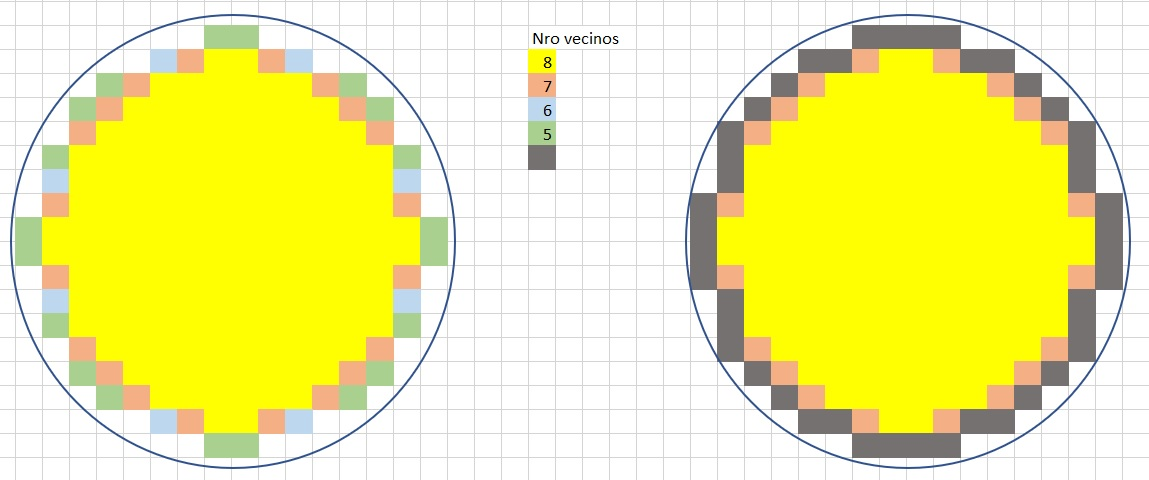

En la figura se presenta un esquema de cuántos vecinos tiene cada pixel (imagen izquierda), y luego a la derecha en píxeles grises se muestra los píxeles que nuestro código considera para el cálculo de perímetro.

Este cálculo se podría haber realizado teniendo en cuenta los píxeles que posean menos de 8 vecinos. Sin embargo, se decidió utilizar el mismo criterio que utiliza la función RegionProps para poder comparar los resultados con los obtenidos a través de esa función. (Documentación Regionprops: http://matlab.izmiran.ru/help/toolbox/images/regionprops.html#512895)

El perímetro de una gota se almacenó *perimetro_n_gota*. 

Por último, para guardar los perímetros y vecinos de todas las gotas presentes en la imagen, se crearon las variables correspondientes y se guardó la información a través de un append. Es decir, cada vez que analizaba una gota, guardaba (con el append) la información en la variable.

In [20]:
def fit_elipse(x, y):
    """
    Trato mis gotas como elipses.
    Obtengo los coeficientes a, b, c, d, e, f de la ecuación que representa la elipse. 
    (Ver explicación en texto.)
    """

    D1 = np.vstack([x**2, x*y, y**2]).T #Función para transponer más sencilla (no es necesario aclarar ejes)
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1 #Uso @ para la multiplicación de matrices comun (fila x columna)
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T #Calculo la inversa
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M) #Resuelvo el problema de autovalores y autovectores
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()


def cart_to_pol(coeficientes): #Paso los coeficientes de cartesianas a polares 
    """
    Al tener los coeficientes de la elipse en coordenadas polares, ya sé que mis coeficientes
    van a representar el centro de la elipse, los ejes mayor y menor, la excentricidad y el ángulo
    de rotación de la elipse (Que son los parámetros que yo quiero calcular)
    x0 = centro de masa en x
    y0 = centro de masa en y
    ap = semieje mayor
    bp = semieje menor
    e = excentricidad
    phi = ángulo de inclinación de la elipse. (Ángulo entre el semieje mayor y el eje x)
    """

    # Nombre los coeficientes
    a = coeficientes[0]
    b = coeficientes[1] / 2
    c = coeficientes[2]
    d = coeficientes[3] / 2
    f = coeficientes[4] / 2
    g = coeficientes[5]

    rad = b**2 - a*c #Radicando de la raíz
    if rad > 0:
        raise ValueError('Los coeficientes no corresponden a una elipse. b^2 - 4ac debe ser negativo')

    #Calculo el centro de masa de la elipse 
    x0, y0 = (c*d - b*f) / rad, (a*f - b*d) / rad

    #Separo la cuenta en "trozos" para que sea más legible
    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    
    #Semiejes mayor y menor
    ap = np.sqrt(num / rad / (fac - a - c))
    bp = np.sqrt(num / rad / (-fac - a - c))

    #Sólo por nomenclatura, debo asegurarme que el semieje mayor > semieje menor
    #Sino, quiere decir que los puse al revés, y los tengo que cambiar
    ancho_vs_alto = True
    if ap < bp:
        ancho_vs_alto = False
        ap, bp = bp, ap

    #Calculo la excentricidad de la elipse
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    #Ángulo de inclinación del semieje mayor de la elipse respecto del eje x (calculado en sentido antihorario)
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not ancho_vs_alto:
        phi += np.pi/2 #Si le erré en cuál era el eje mayor-menor, corro el ángulo en 90° para tener el correcto
    phi = phi.real % np.pi #Con % obtengo el resto de esa división
    #Me quedo con el resto de la división para que el ángulo esté entre 0 y 2pi que es lo que a mí 
    #me interesa (No me importa si da muchas vueltas (phi > 2pi))

    return x0, y0, ap, bp, e, phi

Por último, se tienen dos funciones que permiten obtener los parámetros de centro de masa (de una nueva forma), los ejes mayor y menor de las gotas, su excentricidad y su ángulo de inclinación respecto del eje horizontal.

La función *fit_elipse* está basada en el algoritmo "Numerically stable direct least squares fitting of ellipses" de Halir y Flusser.

En primer lugar, recordemos las ecuaciones de cónicas:

\begin{equation} A x^{2} + B xy + C y^{2} + Dx + Ey + F = 0 \end{equation}

La función permite obtener los parámetros A, B, C, D, E, F, para así poder obtener la información necesaria de la elipse. 

Para esto se debe resolver el sistema de ecuaciones dado por 6 ecuaciones y 6 incógnitas. En particular, se resuelve el sistema utilizando el cálculo de autovalores y autovectores visto en Algebra y Geometría.

Una vez obtenidos los valores de los coeficientes de la ecuación de la cónica a través de *fit_elipse* se utiliza la función *cart_to_pol*. Esta última hace la conversión de los parámetros (obtenidos en coordenadas cartesianas) a coordenadas polares. Esto es muy útil dado que en estas coordenadas (mucho más apropiadas para parametrizar una elipse) los coeficientes pasan a representar los parámetros que se consideran de interés, es decir, los ejes, excentricidad, centro geométricos y ángulo de inclinación. 

En particular se debe cumplir, al tratarse de elipses, la siguiente relación:

\begin{equation} B^{2} - AC < 0 \end{equation}

Es por eso, que se pide que la variable *rad* cumpla con este criterio. De lo contrario, se avisa al usuario que sus valores no cumplen con la forma de elipse. 

A continuación simplemente se realizan las conversiones apropiadas para el paso de los coeficientes.

Para mantener la nomenclatura que se eligió en la función donde *ap* es el eje mayor y *bp* el eje menor, debe asegurarse que al haber obtenido estos ejes, se mantenga la relación \begin{equation} ap > bp \end{equation}, de lo contrario se deben intercambiar los valores de las variables.

Por último, cuando se realiza el cálculo del ángulo de inclinación *phi*, inicialmente este valor puede devolver cualquier valor (en radianes). Sin embargo, para unificar criterios, se lleva a este valor a que se encuentre en la primer vuelta de la elipse. Es decir, se pide que el ángulo esté restringido entre \begin{equation} [0, 2\pi] \end{equation}.

Además, se debe asegurar estar calculando el ángulo correcto, entre el eje mayor y la horizontal. Por eso, se pide que si no se cumple que \begin{equation} ap > bp \end{equation}, al ángulo se le sumen 90°. Esto permite corregir el error (si se estaba midiendo el ángulo entre el eje menor y el eje, al sumarle los 90° se pasa a trabajar con el eje mayor, dado que este forma un ángulo recto con el eje menor). 



Código

En primer lugar, se cargó la imagen, se binarizó y se ploteó.

Además, se inicializaron variables que se utilizaron más adelante, se obtuvo el tamaño de la imagen, y se creó una copia de la misma. 

Es importante mencionar que fue necesario utilizar la función *np.copy* para generar la copia de la imagen pasando por valor y no por referencia. Dado que si hubiese pasado por referencia, *im_YIQ_new* = *im_YIQ* en todo momento del código, y eso no es lo que se buscaba. 

Las variables que inicialmente no tienen ningun dato, fueron creciendo a medida que corrió el código, dado que se les agregó información con los correspondientes .append que figuran en la función *pixel_analisis*. 

Estas variables deben ser inicializadas fuera de dicha función, ya que deben almacenar la información de todas las gotas analizadas, y la función *pixel_analisis* borra la información de la gota que ya analizó cada vez que corre. (Ver ciclo while más abajo).

In [21]:
inp = input('Si desea ver los gráficos en los que las gotas analizadas van desapareciendo ponga Si, sino ponga No.')

Si desea ver los gráficos en los que las gotas analizadas van desapareciendo ponga Si, sino ponga No.No


En primer lugar, se le da la opción al usuario de si desea o no ver todas las imágenes a medida que las gotas van desapareciendo.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


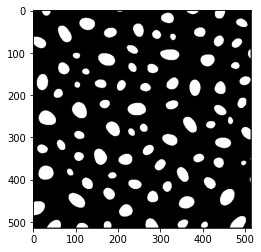

In [22]:
#Leo la imagen
im = get_image('https://drive.google.com/uc?export=download&id=1-lJq3eV32PfQ4ssK2-sjvsVOPpgIUYuv')

im_YIQ = rgbatoyiq(im) #la convierto a YIQ

#Binarizo la imagen
im_YIQ = np.where(im_YIQ <= 0.5, 0, 1)

l, m = im_YIQ.shape[0], im_YIQ.shape[1]

im_YIQ_bin = yiqtorgb(im_YIQ)

plt.imshow(im_YIQ_bin) 
plt.show()

im_YIQ_new = np.copy(im_YIQ) # paso por VALOR no por referencia (sino las variables son SIEMPRE iguales)

gotas_list = [] #la inicializo fuera del while pq sino cada vez que borro una gota, esto vuelve a cero, y no me sirve
perimetros_tot_gota =[] #también tengo que inicializar afuera del while, sino se me borra la info
i_values = [-1, 0, 1]
j_values = [-1, 0, 1]
rcm_gotas = []

Comienzo análisis de píxeles:

Se utilizó la función *pixel_analisis*. Se ejecutó dentro de un ciclo *while*. De esta forma, el código deja de funcionar cuando ya no hayan más gotas (píxeles con luminancia Y=1) en la imagen. 

Se realizó el ploteo de *im_YIQ_new* a medida que se van analizando las gotas, para ver cómo estas desaparecen de la imagen. 

In [23]:
#Arranco a analizar los píxeles

while im_YIQ_new[:,:,0].any() == 1: #el código termina cuando ya no tengo pixeles blancos en la imagen (no hay más manchas)
    
    pixel_analisis(im_YIQ_new, im_YIQ, i_values, j_values, gotas_list, rcm_gotas, perimetros_tot_gota)

A continuación se realizaron los cálculos (seguidos del correspondiente plot) de perímetro, área y posición del centro de masa (versión 1) de cada gota. 

El calculo de perímetro se realizó en la función *pixel_analisis* como mencioné con anterioridad. 

Para el cálculo del área de gotas, simplemente se contaron cuántos píxeles tenía asignados en la variable *gotas_list* para cada vez que corrió el ciclo while anterior, es decir, para cada gota eliminada. La suma de estos píxeles me da el área de cada gota. 

Por último, para el centro de masa, se calculó el promedio de la posición de los píxeles de la variable *gotas_list* para cada columna (es decir, la posición del centro de masa en el eje horizontal y en el vertical). 

Es importante mencionar que para una correcta visualización de la superposición de los centros de masa (variable ploteada con *plt.plot*) y la imagen original (graficada con *plt.imshow*) se debió trasponer esta última. Esto fue necesario dado que el origen de coordenadas de las imágenes no coincide con el eje de coordenadas "común" utilizado para el ploteo de datos. 

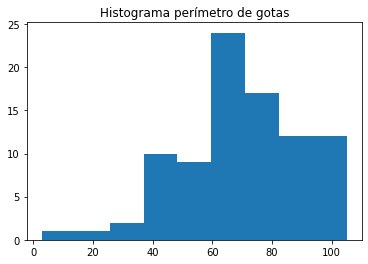

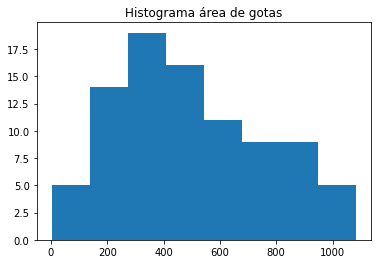

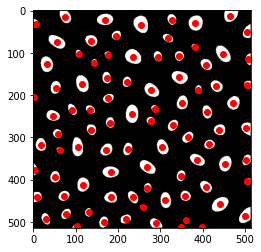

In [24]:
#Cálculo y ploteo del perímetro de cada gota
plot1 = plt.figure(1)
plt.hist(perimetros_tot_gota, bins='auto')  #mi histograma está en el TP4 en colab
plt.title("Histograma perímetro de gotas")
    
nro_gotas = len(gotas_list) #cuento el nro de gotas

#Cálculo el área y rcm de cada gota
area_gotas = [None]*nro_gotas #creo una matriz del mismo tamaño que nro_gotas para poder recorrerla en el for que sigue
rcm_gotas = [None]*nro_gotas

for gota in range(0, len(gotas_list)):
    area_gotas[gota] = len(gotas_list[gota]) #creo una matriz con el área de cada gota para despues poder hacer el histograma de áreas

    rcm_gotas[gota] = np.mean(np.array(gotas_list[gota]), axis=0) #array con el CM de cada gota
    
rcm_gotas = np.array(rcm_gotas) #lo convierto en array para poder plotear fácil
    
#Ploteo el área de cada gota
plot2 = plt.figure(2)
plt.hist(area_gotas, bins='auto') 
plt.title("Histograma área de gotas")

#Ploteo el CM de cada gota
plot3 = plt.figure(3)
plt.imshow(im_YIQ_bin.transpose(1,0,2)) 
plt.plot(rcm_gotas[:,0], rcm_gotas[:,1], 'ro')
plt.show()

Una vez terminado el análisis inicial de la imagen se procedió a calcular el resto de los parámetros. Para esto fue necesario el uso de las funciones *fit_elipse* y *cart_to_pol*. 



In [25]:
#%% Utilizo filtro Sobel para detectar los bordes de mis gotas

Gx = np.array([[-1, 0, 1], 
               [-2, 0, 2],
               [-1, 0, 1]])
Gy = np.array([[1, 2, 1], 
               [0, 0, 0],
               [-1, -2, -1]])

img_filt_Gx = convolve2d(im_YIQ[:,:,0], Gx, 'same')

img_filt_Gy = convolve2d(im_YIQ[:,:,0], Gy, 'same')

# Interpreto la imagen como número complejo
img_filt = img_filt_Gx + 1j * img_filt_Gy

# El módulo sirve para detectar bordes
# La fase indica hacia donde apunta el gradiente

modulo = np.abs(img_filt)
modulo = modulo / abs(np.max(modulo))   # Normalizo el módulo

borde_gotas = np.copy(im_YIQ)

borde_gotas[:,:,0] = np.where(modulo <= 0.5, 0, 1)

Yero_new = np.copy(borde_gotas)

Para la función *fit_elipse* se deben conocer los píxeles que pertenecen al borde de la elipse. Estos píxeles serán los que se le asignaran como parámetros de entrada a la función para que funcione. Por lo tanto, fue necesario hallar dichos píxeles.

Con este propósito se utilizaron los filtros vistos en la teoría. Inicialmente había elegido trabajar con el filtro Laplaciano seguido de una dilatación, dado que el Laplaciano me borraba algunos píxeles que sí pertenecían al perímetro. Sin embargo, luego de un repaso, decidí cambiar y trabajar sólo con el filtro Sobel. 

Llegué a la conclusión que mi idea original de usar filtro Laplaciano funcionaba por el tipo de imagen con el que estaba trabajando ya que sólo tenía altas frecuencias en el borde de la imagen, pero que el filtro Sobel que es propiamente un filtro de detección de bordes era mucho más apropiado. Además, el resultado de este último filtro era lo suficientemente bueno como para no necesitar de la aplicación de un segundo filtro que complemente. 

In [26]:
#Analizo los píxeles en el perímetro de las gotas
gotas_list_ero = [] #la inicializo fuera del while pq sino cada vez que borro una gota, esto vuelve a cero, y no me sirve
perimetros_tot_gota_ero =[] #también tengo que inicializar afuera del while, sino se me borra la info
rcm_gotas_ero = []

while Yero_new[:,:,0].any() == 1: #el código termina cuando ya no tengo pixeles blancos en la imagen (no hay más gotas)
    pixel_analisis(Yero_new, borde_gotas, i_values, j_values, gotas_list_ero, rcm_gotas_ero, perimetros_tot_gota_ero)

plt.show()

Una vez obtenida la imagen (matriz) donde los únicos píxeles con luminancia Y=1 son los pertenecientes al borde, se volvió a utilizar la función *pixel_analisis*. De esta forma, se repitió el mismo procedimiento para obtener los píxeles pertenecientes a cada gota, sólo que esta vez se aseguró que estos píxeles pertenezcan exlcusivamente al perímetro de la gota. 

Ahora sí me están dadas las condiciones para poder utilizar la función *fit_elipse*

In [27]:
#Guardo los datos de todas las gotas en una lista.
rcm_x = [] #Inicializo variables
rcm_y = []
long_ax = []
short_ax = []
exc = []
phi_tot = []

for gota in np.array(gotas_list_ero): #Recorro las gotas
    x = [] #Inicializo una x para cada gota
    y = [] #Idem
    for coordenada in np.array(gota): #Recorro los píxeles de cada gota
        x.append(coordenada[0]) #Guardo las coordenadas x para la gota
        y.append(coordenada[1]) #Idem

    x = np.float64(np.array(x)) #Convierto a np.array y tipo de dato float64 (lo necesito para poder correr fit_elipse)
    y = np.float64(np.array(y))
    
    if len(x) > 40 and len(y) > 40: #Descarto las gotas muy pequeñas, con pocos píxeles de información ya que con pocos datos la elipse que me genera el fiteo es cualquier cosa
      coeficientes = fit_elipse(x, y)
      x0, y0, ap, bp, e, phi = cart_to_pol(coeficientes)
      
      rcm_x.append(x0) #apendo los datos obtenidos para cada gota en una misma lista.
      rcm_y.append(y0)
      long_ax.append(ap)
      short_ax.append(bp)
      exc.append(e)
      phi_tot.append(phi)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


Nuevamente se decidió inicializar variables vacías para guardar la información de todas las gotas. 

Con dos ciclos *for*, uno para recorrer todas las gotas, y otro para recorrer todos los píxeles de la gota, se calcularon los coeficientes de la ecuación de la elipse y luego se transformaron a coordenadas polares para obtener los parámetros deseados. 

Nuevamente, una vez obtenido el dato de cada gota, se realizaron los appends correspondientes para guardar toda la información de las gotas en listas.

Todo este procedimiento se realizó bajo un ciclo *if* que garantizara que las gotas que se estaban fiteando tuvieran información suficiente (cantidad de píxeles suficiente) para un fiteo adecuado.

Luego de varias pruebas se consideró que aquellas gotas que tuvieran menos de 40 píxeles de información, no serían adecuadas para el trabajo.

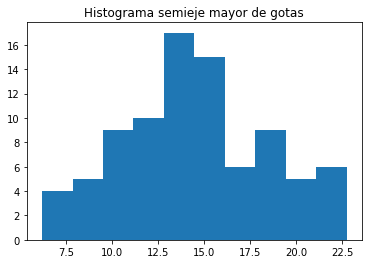

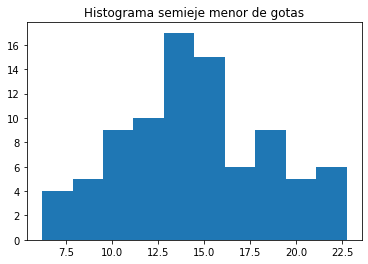

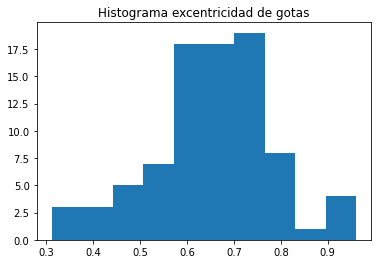

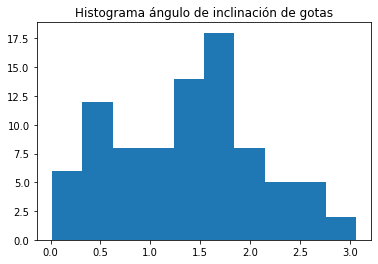

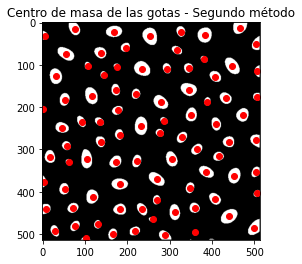

In [28]:
#Ploteo parámetros

#Ploteo el semieje mayor de cada gota
plot4 = plt.figure(4)
plt.hist(np.float64(long_ax), bins=None) 
plt.title("Histograma semieje mayor de gotas")

#Ploteo el semieje menor de cada gota
plot5 = plt.figure(5)
plt.hist(long_ax, bins=None) 
plt.title("Histograma semieje menor de gotas")

#Ploteo la excentricidad de cada gota
plot6 = plt.figure(6)
plt.hist(exc, bins=None)
plt.title("Histograma excentricidad de gotas")

#Ploteo el ángulo de inclinación de cada gota
plot7 = plt.figure(7)
plt.hist(phi_tot, bins = None) 
plt.title("Histograma ángulo de inclinación de gotas")

#Ploteo el CM de cada gota según este cálculo
plot8 = plt.figure(8)
plt.imshow(im_YIQ_bin.transpose(1,0,2)) 
plt.plot(np.abs(rcm_x), np.abs(rcm_y), 'ro')
plt.title("Centro de masa de las gotas - Segundo método")

plt.show()

Finalmente se realizó el ploteo de todos los parámetros obtenidos en forma de Histograma para ver la distribución que seguían los mismos. 

Además, se realizó nuevamente el ploteo de los centros de masa de las gotas pero ahora con el nuevo método.

In [29]:
#Guardo los parámetros de interés en archivos para poder analizarlos cuando sea necesario

with open("parametros.txt","w") as f:
    for (perimetros_tot_gota, area_gotas, rcm_x, rcm_y, long_ax, short_ax, exc, phi_tot) in zip(perimetros_tot_gota, area_gotas, rcm_x, rcm_y, long_ax, short_ax, exc, phi_tot):
        f.write("{0},{1},{2},{3}, {4}, {5}, {6}, {7}\n".format(perimetros_tot_gota, area_gotas, rcm_x, rcm_y, long_ax, short_ax, exc, phi_tot))

Por último, se guardaron los datos obtenidos en un archivo de texto para poder acceder a ellos fácilmente para un posterior análisis.

### Conclusiones

Pude realizar todo el trabajo de acuerdo a lo planeado. Además, utilizando una imagen creada artificialmente por MATLAB pude contrastar mis resultados para asegurarme de que estuvieran correctos.

El parámetro que más dificultad me generó fue el perímetro de las gotas. Para este caso, hay muchas aproximaciones válidas, entre ellas la utilizada en este trabajo. Sin embargo, el cálculo exacto del perímetro es altamente complejo. 

Un aspecto positivo, fue que además de poder contrastar la precisión de mi código con otro ya existente utilizando imágenes artificiales, también pude, para el caso del cálculo de los centros de masas, comparar dos métodos distintos proporcionados en mi código para los valores. Observando los ploteos correspondientes, vemos que ambos métodos funcionan correctamente.